# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$w_{new} = w_{old} -  \frac{2\alpha}{N} X_{n}^T(X_{n} * w_{old} - y_{n}) - \frac{2\alpha}{C}w_{old} $$


Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***
$$w_{new} = w_{old} - \alpha(\frac{1}{N}\sum_{i=1}^N(( \sigma(<x_{i}, w>) - y_{i})x_i) + \frac{2w}{C}) $$

в матричной форме:
$$w_{new} = w_{old} - \alpha(\frac{1}{N}(X^T( \sigma(Xw) - y)) + \frac{2w}{C}) $$


Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***
$$ H_{i,j} = \frac{\partial^2L(w)}{\partial w_{i}\partial w_{j}} $$  

$$L(w) =  \frac{1}{n}\left[\sum_i (\langle x_{i},w \rangle - y_i) ^ 2 \right] $$  

В матричном виде

$$ L(w) = \frac{1}{n} (Xw - y)^T(Xw - y) + \frac{1}{C}w^Tw = \frac{1}{n} (w^TX^TXw - w^TX^Ty - y^TXw + y^Ty)$$  


$$ \nabla L(w) = \frac{1}{n} (X^TX + X^TX)w - 2X^Ty + \frac{1}{C}(I^T + I)w = \frac{2}{n} (X^TXw - X^Ty)$$  

$$ \nabla^2 L(w) = \frac{2}{n} X^TX$$  

$$ \forall z: z^T (X^TX)(X^TX)^T z = \left[(X^TX)^Tx\right]^T \left[(X^TX)^Tx\right] > 0$$  

Значит это и правда точка минимума. Теперь найдем точное решение.

$$ L(w) = \frac{2}{n} (X^TXw - 2X^Ty) + \frac{2}{C}w$$  

$$ X^TXw - X^Ty + \frac{n}{C}w = 0 $$  

$$ (X^TX + \frac{n}{C} I)w = X^Ty$$  

$$ w = (X^TX + \frac{n}{C} I)^{-1}X^Ty $$  

Благодаря регуляризации матрица слева обратима

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

По условию экстремума:

$$ \frac{\partial E(L|x_i)}{\partial a} = -p(y_i = 1|x_i)\frac{1}{a(x_i)} + p(y_i = 0|x_i) \frac{1}{1 - a(x_i)} = 0$$  

$$ p(y_i = 1|x_i)\frac{1}{a(x_i)} = (1 - p(y_i = 1|x_i))\frac{1}{1 - a(x_i)}$$  

$$ p(y_i = 1|x_i)(1 - a(x_i)) = a(x_i)(1 - p(y_i = 1|x_i)) $$  

$$ p(y_i = 1|x_i) = a(x_i) $$ 

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Думаю, не нужно, т.к. он отвечает за смешение, а если его ограничивать регуляризацией, то его значение может не стать достаточным для оптимального решения

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [122]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [123]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [127]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [128]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [130]:
from sklearn.utils import shuffle as sh
def batch_generator(X, y, shuffle=True, batch_size=10):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if shuffle:
        X, y = sh(X, y, random_state=None)
    X_batch = np.ndarray((0, X.shape[1]))
    y_batch = np.array([])
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [137]:
#%%pycodestyle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from sklearn.base import BaseEstimator, ClassifierMixin

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    ## Your code Here
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    

    def __init__(self, batch_generator = batch_generator, C=1, alpha=0.01, max_epoch=1000,\
                 model_type='lin_reg', threshold=0.5, batch_size=10):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.threshold = threshold
        self.batch_size = batch_size
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
                        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            a = np.dot(X_batch, self.weights)
            loss = np.sum(a - y_batch)**2 / X_batch.shape[0]
        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, self.weights))
            loss = -np.sum(y_batch * np.log(a) + (1- y_batch) * np.log(1 - a)) / X_batch.shape[0]
        return loss + np.sum(self.weights[1:] ** 2) / self.C
    


    def calc_loss_grad(self, X_batch, y_batch):
        if self.model_type == 'lin_reg':
            loss_grad = 2 * np.dot(np.dot(X_batch, self.weights) - y_batch, X_batch) / X_batch.shape[0]
        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, self.weights))
            loss_grad = np.dot(a - y_batch, X_batch) / X_batch.shape[0]
        return loss_grad + 2 * np.array([0] + list(self.weights[1:])) / self.C

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        self.X = np.concatenate((np.ones(X.shape[0]).reshape(-1,1), X), axis=1)
        self.y = y        
        self.weights = 2 * np.random.random_sample((X.shape[1] + 1, )) - 1
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(self.X, self.y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
        return self
    
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if len(X.shape) == 1:
            X = np.reshape(X, (1,-1))
        X = np.concatenate((np.ones(X.shape[0]).reshape(-1,1), X), axis=1)
        if self.model_type == 'lin_reg':
            y_hat1 = np.dot(X, self.weights)
            y_hat = np.heaviside(y_hat1 - self.threshold, 0)
        elif self.model_type == 'log_reg':
            y_hat1 = sigmoid(np.dot(X, self.weights))
            y_hat = np.heaviside(y_hat1 - self.threshold, 0)
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat.astype(int)

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [138]:
def plot_decision_boundary(clf):
    ## Your code Here
    w0, w1, w2, *_ = clf.weights
    x = np.linspace(-4, 8, 50)
    # = -w0 + x * w1
    y = -x*(w1/w2) -w0/w2
    plt.plot(x, y)

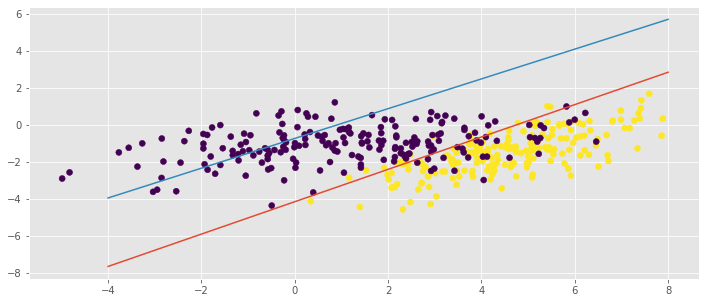

In [139]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
log_reg = MySGDClassifier(model_type='log_reg', C=1000, max_epoch=1000)
log_reg.fit(X,y)
plot_decision_boundary(log_reg)
lin_reg = MySGDClassifier(model_type='lin_reg', C=1000, max_epoch=1000)
lin_reg.fit(X,y)
plot_decision_boundary(lin_reg)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [127]:
from sklearn.datasets import make_classification

In [128]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [129]:
## Your Code Here
log_reg0 = MySGDClassifier(model_type='log_reg', C=1000, max_epoch=50, alpha=0.1)
log_reg0.fit(X,y)
log_reg1 = MySGDClassifier(model_type='log_reg', C=1000, max_epoch=50, alpha=0.01)
log_reg1.fit(X,y)
log_reg2 = MySGDClassifier(model_type='log_reg', C=1000, max_epoch=50, alpha=0.001)
log_reg2.fit(X,y)
log_reg3 = MySGDClassifier(model_type='log_reg', C=1000, max_epoch=50, alpha=1)
log_reg3.fit(X,y)

MySGDClassifier(C=1000, alpha=1,
                batch_generator=<function batch_generator at 0x7f7703249200>,
                batch_size=10, max_epoch=50, model_type='log_reg',
                threshold=0.5)

[]

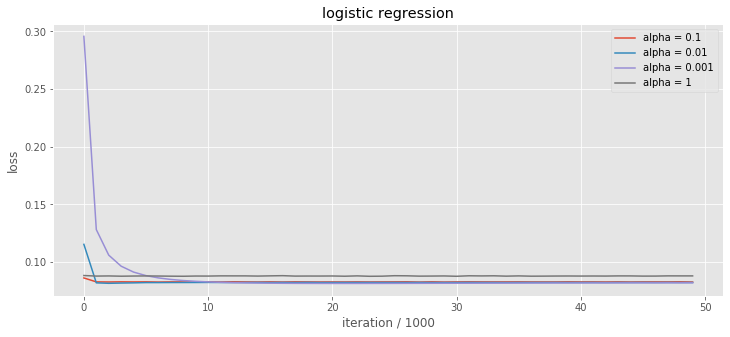

In [130]:
N = 10000
xx = list(range(50))
mean_loss = []
for i in range(0, len(log_reg0.errors_log['iter']), N):
    mean_loss.append(np.mean(log_reg0.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.1")

mean_loss = []
for i in range(0, len(log_reg1.errors_log['iter']), N):
    mean_loss.append(np.mean(log_reg1.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.01")

mean_loss = []
for i in range(0, len(log_reg2.errors_log['iter']), N):
    mean_loss.append(np.mean(log_reg2.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.001")

mean_loss = []
for i in range(0, len(log_reg3.errors_log['iter']), N):
    mean_loss.append(np.mean(log_reg3.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 1")

plt.title('logistic regression')
plt.ylabel('loss')
plt.xlabel('iteration / 1000')
plt.legend()
plt.plot()

In [131]:
lin_reg0 = MySGDClassifier(model_type='lin_reg', C=1000, max_epoch=50, alpha=0.1)
lin_reg0.fit(X,y)
lin_reg1 = MySGDClassifier(model_type='lin_reg', C=1000, max_epoch=50, alpha=0.01)
lin_reg1.fit(X,y)
lin_reg2 = MySGDClassifier(model_type='lin_reg', C=1000, max_epoch=50, alpha=0.001)
lin_reg2.fit(X,y)

MySGDClassifier(C=1000, alpha=0.001,
                batch_generator=<function batch_generator at 0x7f7703249200>,
                batch_size=10, max_epoch=50, model_type='lin_reg',
                threshold=0.5)

[]

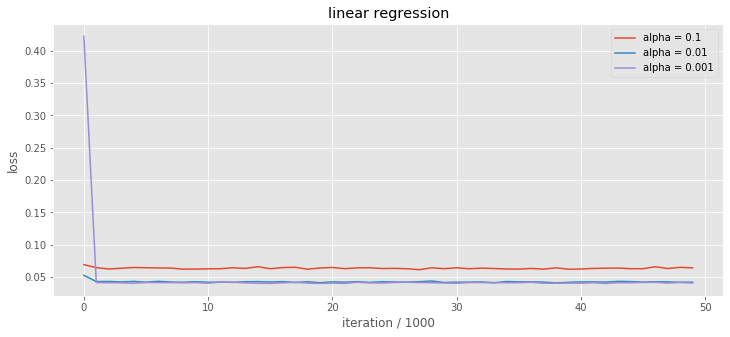

In [132]:
N = 10000
xx = list(range(50))
mean_loss = []
for i in range(0, len(lin_reg0.errors_log['iter']), N):
    mean_loss.append(np.mean(lin_reg0.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.1")

mean_loss = []
for i in range(0, len(lin_reg1.errors_log['iter']), N):
    mean_loss.append(np.mean(lin_reg1.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.01")

mean_loss = []
for i in range(0, len(lin_reg2.errors_log['iter']), N):
    mean_loss.append(np.mean(lin_reg2.errors_log['loss'][i : i + N]))
plt.plot(xx, mean_loss, label="alpha = 0.001")

plt.title('linear regression')
plt.ylabel('loss')
plt.xlabel('iteration / 1000')
plt.legend()
plt.plot()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

**Как мы видим, логистическая регрессия плохо себя показывает при alpha = 1. Линейная регрессия плохо себя показывает уже при alpha = 0.1, а лучше всего при alpha = 0.01**

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

[]

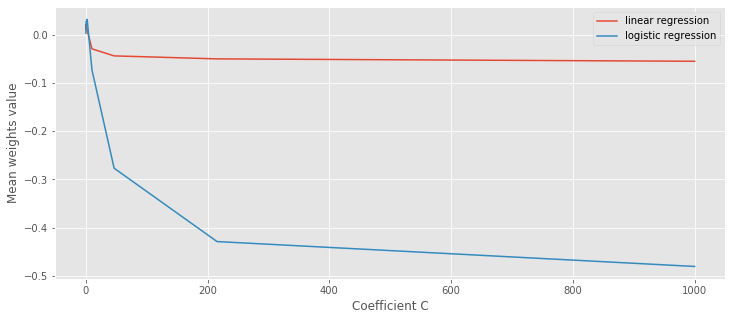

In [133]:
## Your Code Here
weights_lin = []
for C in np.logspace(3, -3, 10):
    linear = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=0.01, max_epoch=50, C=C)
    linear.fit(X, y)
    weights_lin.append(np.mean(linear.weights))
weights_log = []
for C in np.logspace(3, -3, 10):
    logistic = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.01, max_epoch=50, C=C)
    logistic.fit(X, y)
    weights_log.append(np.mean(logistic.weights))
plt.plot(np.logspace(3, -3, 10), weights_lin, label='linear regression')
plt.plot(np.logspace(3, -3, 10), weights_log, label='logistic regression')
plt.ylabel('Mean weights value')
plt.xlabel('Coefficient C')
plt.legend()
plt.plot()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

**Да, я доволен**

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [118]:
doc_to_title = {}
with open('./project_files/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [119]:
import pandas as pd
train_data = pd.read_csv('./project_files/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [120]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [9]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

**Сначала ищем коэффициент С для логистической регрессии**

In [49]:
from sklearn.model_selection import KFold

In [103]:
def find_best_C_roughly():
    scores1 = []
    for C in np.logspace(3, -2, 15):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.01, max_epoch=25, C=C)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_reg.fit(data_train, target_train)
            pred = my_reg.predict(data_val)
            score = f1_score(target_val, pred)
            scores.append(score / 5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' C= ', C)
    return scores1
log_reg_c = find_best_C_roughly()

mean f1 score among all folds:  0.5082075874976891  C=  1000.0
mean f1 score among all folds:  0.5185252077731215  C=  439.3970560760791
mean f1 score among all folds:  0.5180129679178929  C=  193.06977288832496
mean f1 score among all folds:  0.5304813903351311  C=  84.83428982440721
mean f1 score among all folds:  0.5288038902838775  C=  37.2759372031494
mean f1 score among all folds:  0.551587305045873  C=  16.378937069540637
mean f1 score among all folds:  0.5644124781246131  C=  7.196856730011521
mean f1 score among all folds:  0.5801432757138356  C=  3.1622776601683795
mean f1 score among all folds:  0.6003258567398656  C=  1.3894954943731375
mean f1 score among all folds:  0.6093627269938084  C=  0.6105402296585326
mean f1 score among all folds:  0.6111335624502501  C=  0.2682695795279725
mean f1 score among all folds:  0.6120155969358873  C=  0.11787686347935866
mean f1 score among all folds:  0.6100702496398658  C=  0.05179474679231213
mean f1 score among all folds:  0.6104977

**Ищем коэффициент alpha**

In [105]:
def find_best_alpha_roughly():
    scores1 = []
    for alpha in np.logspace(-1.5, -4, 15):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=alpha, max_epoch=25)            
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' alpha= ', alpha)
    return scores1
lin_reg_alpha = find_best_alpha_roughly()

mean f1 score among all folds:  0.24817838812169074  alpha=  0.03162277660168379
mean f1 score among all folds:  0.48895884890104546  alpha=  0.020961799924531267
mean f1 score among all folds:  0.5381455946833875  alpha=  0.013894954943731374
mean f1 score among all folds:  0.4111390362381264  alpha=  0.00921055317689482
mean f1 score among all folds:  0.48234784496464356  alpha=  0.006105402296585327
mean f1 score among all folds:  0.5032387478852118  alpha=  0.004047089950759761
mean f1 score among all folds:  0.5092045827123219  alpha=  0.002682695795279727
mean f1 score among all folds:  0.49089964100626005  alpha=  0.0017782794100389228
mean f1 score among all folds:  0.49255488267308456  alpha=  0.0011787686347935866
mean f1 score among all folds:  0.480582868157964  alpha=  0.0007813707376518093
mean f1 score among all folds:  0.4974732205266535  alpha=  0.0005179474679231213
mean f1 score among all folds:  0.46764201926294124  alpha=  0.00034333200182819933
mean f1 score among

In [106]:
def find_best_alpha_roughly():
    scores1 = []
    for alpha in np.logspace(-1.5, -4, 15):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='log_reg', alpha=alpha, max_epoch=25, C=0.12)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' alpha= ', alpha)
    return scores1
log_reg_alpha = find_best_alpha_roughly()

mean f1 score among all folds:  0.5670539684496081  alpha=  0.03162277660168379
mean f1 score among all folds:  0.6123801974533992  alpha=  0.020961799924531267
mean f1 score among all folds:  0.6092734104578517  alpha=  0.013894954943731374
mean f1 score among all folds:  0.6097366485598213  alpha=  0.00921055317689482
mean f1 score among all folds:  0.6130308952125679  alpha=  0.006105402296585327
mean f1 score among all folds:  0.6110657297706944  alpha=  0.004047089950759761
mean f1 score among all folds:  0.6105904087199812  alpha=  0.002682695795279727
mean f1 score among all folds:  0.6112694643089048  alpha=  0.0017782794100389228
mean f1 score among all folds:  0.6116637499276987  alpha=  0.0011787686347935866
mean f1 score among all folds:  0.6114679574060402  alpha=  0.0007813707376518093
mean f1 score among all folds:  0.6111972604368225  alpha=  0.0005179474679231213
mean f1 score among all folds:  0.6110367261608001  alpha=  0.00034333200182819933
mean f1 score among all 

In [107]:
def find_best_max_epoch():
    scores1 = []
    for max_epoch in range(0,301,25):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=0.014, max_epoch=max_epoch)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' max_epoch= ', max_epoch)
    return scores1
lin_reg_alpha = find_best_max_epoch()

mean f1 score among all folds:  0.30560090843506826  max_epoch=  0
mean f1 score among all folds:  0.531566156947957  max_epoch=  25
mean f1 score among all folds:  0.4867322482012699  max_epoch=  50
mean f1 score among all folds:  0.4464387629496155  max_epoch=  75
mean f1 score among all folds:  0.3831716483796954  max_epoch=  100
mean f1 score among all folds:  0.41269955065527336  max_epoch=  125
mean f1 score among all folds:  0.39136772291601335  max_epoch=  150
mean f1 score among all folds:  0.5231401039415986  max_epoch=  175
mean f1 score among all folds:  0.4890280511766318  max_epoch=  200
mean f1 score among all folds:  0.41181281479807674  max_epoch=  225
mean f1 score among all folds:  0.5349726078747984  max_epoch=  250
mean f1 score among all folds:  0.39756403849808986  max_epoch=  275
mean f1 score among all folds:  0.3688754525766031  max_epoch=  300


**Еще несколько раз проверили, на 50 эпохах стабильно получаются хорошие результаты**

In [114]:
def find_best_max_epoch():
    scores1 = []
    for max_epoch in range(0,101,25):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=0.014, max_epoch=max_epoch)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' max_epoch= ', max_epoch)
    return scores1
lin_reg_alpha = find_best_max_epoch()

mean f1 score among all folds:  0.3657518531741729  max_epoch=  0
mean f1 score among all folds:  0.30930625416796276  max_epoch=  25
mean f1 score among all folds:  0.4920054846837775  max_epoch=  50
mean f1 score among all folds:  0.3381615668000475  max_epoch=  75
mean f1 score among all folds:  0.4305949042521487  max_epoch=  100


In [109]:
def find_best_max_epoch():
    scores1 = []
    for max_epoch in range(0,151,25):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.006, max_epoch=max_epoch, C=0.12)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' max_epoch= ', max_epoch)
    return scores1
log_reg_alpha = find_best_max_epoch()

mean f1 score among all folds:  0.3513791608320633  max_epoch=  0
mean f1 score among all folds:  0.6104338276156596  max_epoch=  25
mean f1 score among all folds:  0.6125757394799425  max_epoch=  50
mean f1 score among all folds:  0.6120065265185383  max_epoch=  75
mean f1 score among all folds:  0.6116082413859835  max_epoch=  100
mean f1 score among all folds:  0.6113299202886437  max_epoch=  125
mean f1 score among all folds:  0.6119641859309812  max_epoch=  150


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [116]:
def find_best_threshold():
    scores1 = []
    for threshold in np.linspace(0.1, 0.9, 9):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.006, max_epoch=50, C=0.12, threshold=threshold)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' threshold= ', threshold)
    return scores1
log_reg_alpha = find_best_threshold()

mean f1 score among all folds:  0.44450526537152873  threshold=  0.1
mean f1 score among all folds:  0.44450526537152873  threshold=  0.2
mean f1 score among all folds:  0.44450526537152873  threshold=  0.30000000000000004
mean f1 score among all folds:  0.44450526537152873  threshold=  0.4
mean f1 score among all folds:  0.6100502214845428  threshold=  0.5
mean f1 score among all folds:  0.3150311938325597  threshold=  0.6
mean f1 score among all folds:  0.025798500013950426  threshold=  0.7000000000000001
mean f1 score among all folds:  0.0006611570247933885  threshold=  0.8
mean f1 score among all folds:  0.0  threshold=  0.9


In [117]:
def find_best_threshold():
    scores1 = []
    for threshold in np.linspace(0.4, 0.6, 5):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.006, max_epoch=50, C=0.12, threshold=threshold)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' threshold= ', threshold)
    return scores1
lin_reg_alpha = find_best_threshold()

mean f1 score among all folds:  0.44450526537152873  threshold=  0.4
mean f1 score among all folds:  0.4964559902044251  threshold=  0.45
mean f1 score among all folds:  0.6116222697746656  threshold=  0.5
mean f1 score among all folds:  0.526126766716936  threshold=  0.55
mean f1 score among all folds:  0.265723414537269  threshold=  0.6


In [118]:
def find_best_threshold():
    scores1 = []
    for threshold in np.linspace(0.1, 0.9, 9):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=0.014, max_epoch=50, threshold=threshold)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' threshold= ', threshold)
    return scores1
lin_reg_alpha = find_best_threshold()

mean f1 score among all folds:  0.48117192573338663  threshold=  0.1
mean f1 score among all folds:  0.5695126479999687  threshold=  0.2
mean f1 score among all folds:  0.6092042602328754  threshold=  0.30000000000000004
mean f1 score among all folds:  0.5842187046033888  threshold=  0.4
mean f1 score among all folds:  0.5177368878409144  threshold=  0.5
mean f1 score among all folds:  0.4101406757760471  threshold=  0.6
mean f1 score among all folds:  0.10246751306945481  threshold=  0.7000000000000001
mean f1 score among all folds:  0.20753598517532557  threshold=  0.8
mean f1 score among all folds:  0.14952494311244036  threshold=  0.9


In [126]:
def find_best_threshold():
    scores1 = []
    for threshold in np.linspace(0.2, 0.4, 5):
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train_transformed):
            my_reg = MySGDClassifier(batch_generator, model_type='lin_reg', alpha=0.014, max_epoch=50, threshold=threshold)
            data_train, data_val = X_train_transformed[train_index], X_train_transformed[val_index]
            my_reg.fit(data_train, y_train[train_index])
            pred = my_reg.predict(data_val)

            score = f1_score(y_train[val_index], np.around(pred).astype(int))
            scores.append(score/5)
        scores = sum(scores)
        scores1.append(scores)
        print('mean f1 score among all folds: ', scores, ' threshold= ', threshold)
    return scores1
lin_reg_alpha = find_best_threshold()

mean f1 score among all folds:  0.581586760336285  threshold=  0.2
mean f1 score among all folds:  0.585271988405841  threshold=  0.25
mean f1 score among all folds:  0.6055282191956649  threshold=  0.30000000000000004
mean f1 score among all folds:  0.5968491107528562  threshold=  0.35000000000000003
mean f1 score among all folds:  0.4997063280112276  threshold=  0.4


**Лучшие параметры: 
линейная: alpha = 0.014, max_epochs = 50, threshold = 0.3, 
логистическая: alpha = 0.006, C = 0.12, max_epochs = 50, threshold = 0.5**

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

**Никнейм: Ilyas Suleymanov.
На kaggle логистическая регрессия дала результат 0.60644, линейная 0.59850**

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***